In [454]:
import math as math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [455]:
class Value: 
  
  def __init__(self, data, _children = (), _op='', label=''):
    self.data = data
    self.grad = 0
    self._prev = _children
    self._op = _op
    self.label = label
    
    def _backward():
      pass
    self._backward = _backward
    
    
  @classmethod
  def topological_sort(cls, node):
    topo = []
    visited = set()
    def topological_sort_aux(node):
      if node not in visited:
        visited.add(node)
        for prev in node._prev:
          topological_sort_aux(prev)
        topo.append(node)
    topological_sort_aux(node)
    
    return topo
  
  @classmethod
  def trace(cls, root):
    # build a set of all node and edges in a graph
    nodes, edges = set(), set()
    def visit(node):
      if node not in nodes:
        nodes.add(node)
        for prev in node._prev:
          edges.add((prev, node))
          visit(prev)
    visit(root)
    return nodes, edges
  
  
  def __repr__(self):
    return f'Value(data={self.data}, _prev={self._prev}, _op={self._op}, label={self.label})'
  
  def __radd__(self, other):
    return self.__add__(other)
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      # local gradient of the sum function with respect to self multiplied by the incoming gradient
      self.grad += 1 * out.grad 
      # local gradient of the sum function with respect to other multiplied by the incoming gradient
      other.grad += 1 * out.grad
    
    out._backward = _backward
    return out
  
  def __neg__(self):
    return self * -1
  
  def __sub__(self, other):
    return self + (-other)

  def __rsub__(self, other):
    return other + (-self)
  
  # def __sub__(self, other):
  #   return Value(self.data - other.data)
  def __rmul__(self, other):
    return self.__mul__(other)
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    
    out._backward = _backward      
    return out
  
  def exp(self):
    n = self.data
    out = Value(math.exp(n), (self,), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
      
    out._backward = _backward
    
    return out
  
  def __truediv__(self, other): # self / other
    return self * other**-1
  
  def __rtruediv__(self, other): # other / self
    return other * self**-1
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), 'only int or float supported'
    out = Value(self.data ** other, (self,), 'pow')
     # d(x + 2)**2/dx -> 2(x+2)**(2-1) * d(x+2)/dx 
    def _backward():
      self.grad += other * self.data ** (other - 1) * out.grad
    out._backward = _backward
    return out
    
  
  
  
  def tanh(self):
    n = self.data
    t = (math.exp(2 * n) -1) / (math.exp(2 * n) + 1)
    out = Value(t, (self,), 'tanh')
        
    def _backward():
      self.grad += (1 - t ** 2) * out.grad
    
    out._backward = _backward
    
    return out
  
  def backward(self):
    self.grad = 1
    topo = Value.topological_sort(self)
    nodes, edges = Value.trace(self)
    for n in nodes:
      n.grad = 0.0
    self.grad = 1
    for node in reversed(topo):
      node._backward()
      
    return topo
 



In [456]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label= 'c')
e = a * b; e.label = 'e'
d = e +c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L.grad = 1.0

print('a + b =', a + b)
print('a * b =', a * b)

print('d = a * b + c :=> ', d)

a + b = Value(data=-1.0, _prev=(Value(data=2.0, _prev=(), _op=, label=a), Value(data=-3.0, _prev=(), _op=, label=b)), _op=+, label=)
a * b = Value(data=-6.0, _prev=(Value(data=2.0, _prev=(), _op=, label=a), Value(data=-3.0, _prev=(), _op=, label=b)), _op=*, label=)
d = a * b + c :=>  Value(data=4.0, _prev=(Value(data=-6.0, _prev=(Value(data=2.0, _prev=(), _op=, label=a), Value(data=-3.0, _prev=(), _op=, label=b)), _op=*, label=e), Value(data=10.0, _prev=(), _op=, label=c)), _op=+, label=d)


##### Expression Tree Visualisation

In [457]:
from graphviz import Digraph

def trace(root):
  # build a set of all node and edges in a graph
  nodes, edges = set(), set()
  def visit(node):
    if node not in nodes:
      nodes.add(node)
      for prev in node._prev:
        edges.add((prev, node))
        visit(prev)
  visit(root)
  return nodes, edges

def draw_dot(root):
  
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(uid, label='{'+f'{n.label}|{n._op}, data: {n.data:.4f}\n|grad: {n.grad:.4f}'+'}', shape='record')
    if n._op:
      # if n is an operation node, show the operation symbol
      dot.node( name = uid + n._op, label=n._op, shape='diamond')
      # create an edge from the operation node to n
      dot.edge(uid + n._op, uid)
    
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  
  return dot
  

In [458]:
f.grad = 4.0 # dL/df = 4.0 because L = d*f and dL/df = d and d = 4.0
d.grad = -2 # dL/dd = 1.0 because L = d*f and dL/dd = f and f = -2.0

Calculating dL / dc  

dd/dc  
d = c + e  
dd/dc = 1  
dd/de = 1  

L = d * f   
L = (c + e) * f   

WANT:  dL/dc - ?   
KNOW: dL/dd = -2, dd/dc = 1   
dL/dd = dL/dd * dd/dc   
dL/dc = f * 1 = f   
dL/de = dL/dd * dd/de = -2 * 1 = -2   

In [459]:
c.grad = -2.0
e.grad = -2.0

Calculating dL/da  
dL/da = dL/de * de/da = dL/dd * dd/de  * de/da  
dL/da = -2.0 * -3.0 = 6.0 


In [460]:
a.grad = 6.0
b.grad = -4.0

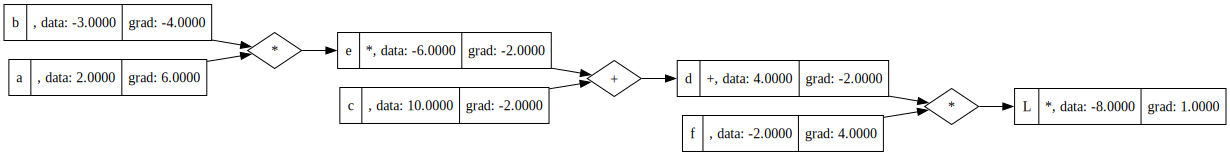

In [461]:
draw_dot(L)

In [462]:
# calculating gradian of L numericallly with step size 0.00001
def gradient_with_fixed_step():
  h = 0.00001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label= 'c')
  e = a * b; e.label = 'e'
  d = e +c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  l1Val = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label= 'c')
  e = a * b; e.label = 'e'
  d = e +c; d.label = 'd'
  d.data += h
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  l2Val = L.data
  
  print((l2Val - l1Val)/h)
  
gradient_with_fixed_step()

-1.9999999999242843


##### Backpropagate throw neuron

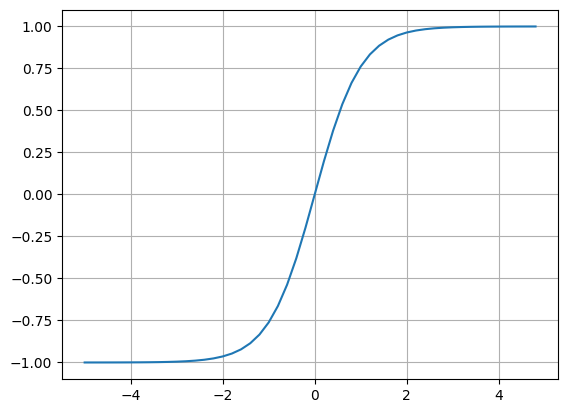

In [463]:

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [464]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


In [465]:
o.grad = 1.0

In [466]:
# a = tanh(n) = (exp(2n) - 1) / (exp(2n) + 1)
# dL/dn = 1 - tanh(n)**2 = 1 - o**2
n.grad = o.grad * (1 - o.data**2)
n.grad

x1w1x2w2.grad = n.grad
b.grad = n.grad

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

w1.grad = x1w1.grad * x1.data
x1.grad = x1w1.grad * w1.data

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


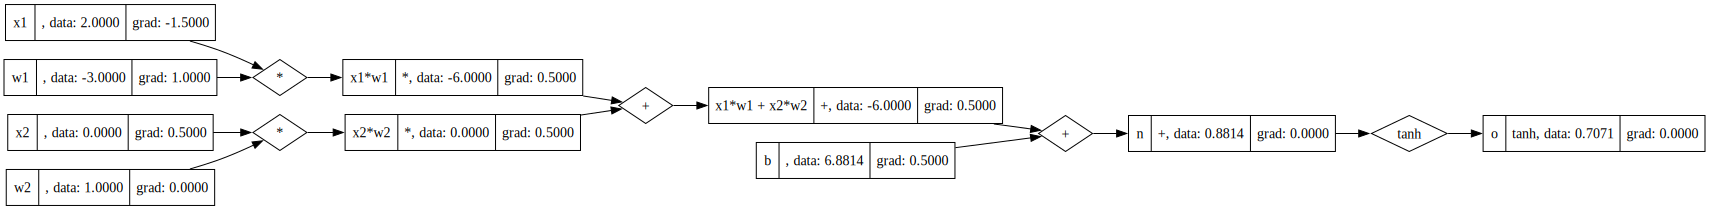

In [467]:
draw_dot(o)

##### Utilizing programmable backward propagation

In [468]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


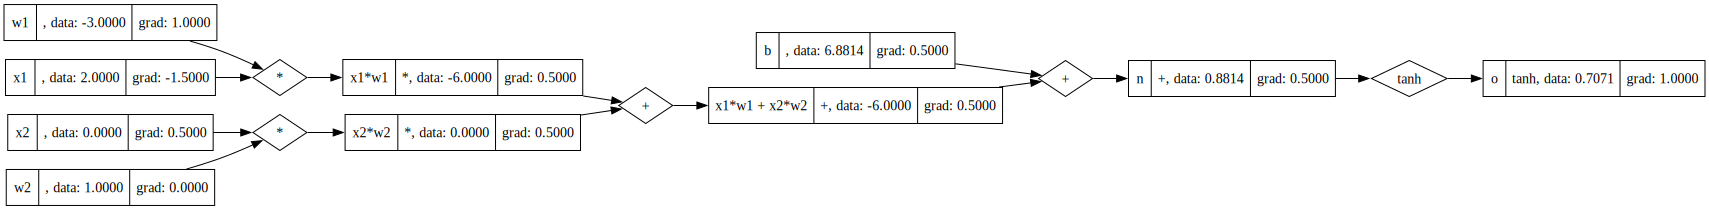

In [469]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

In [470]:
# topologicaly sort the nodes

def topological_sort(node):
  topo = []
  visited = set()
  def topological_sort_aux(node):
    if node not in visited:
      visited.add(node)
      for prev in node._prev:
        topological_sort_aux(prev)
      topo.append(node)
  topological_sort_aux(node)
  return topo
    
print('topological sort')
print('----------------')
print('before sorting')
print('--------------')

nodes, edges = trace(o)
for n in nodes:
  print(n.label)

topo = topological_sort(o)
print('after sorting')
print('--------------')
for n in topo:
  print(n.label)
  

topological sort
----------------
before sorting
--------------
b
n
x2
w2
x1*w1
w1
x2*w2
o
x1*w1 + x2*w2
x1
after sorting
--------------
x1
w1
x1*w1
x2
w2
x2*w2
x1*w1 + x2*w2
b
n
o


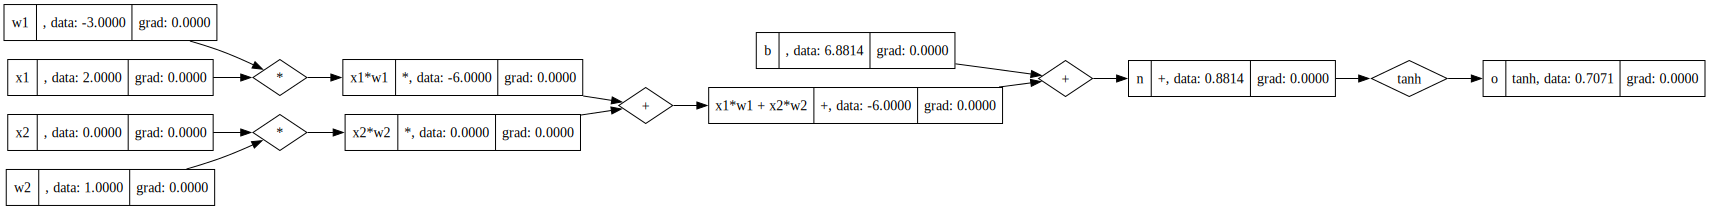

In [471]:
nodes, edges = trace(o)
for n in nodes:
  n.grad = 0.0
draw_dot(o)

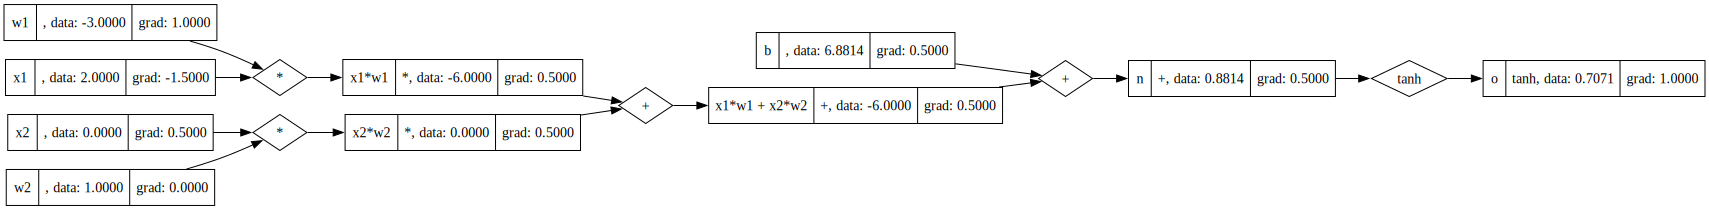

In [472]:
o.grad = 1.0
topo = topological_sort(o)
for node in reversed(topo):
  node._backward()
  
draw_dot(o)

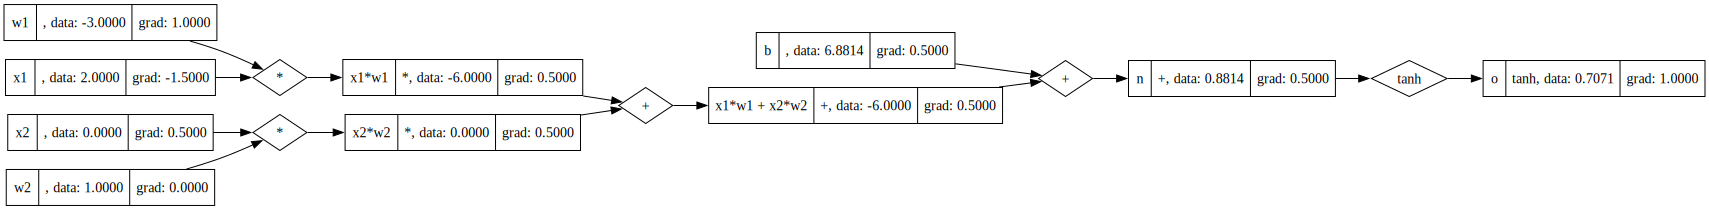

In [473]:
nodes, edges = trace(o)
for n in nodes:
  n.grad = 0.0
  
o.backward()
draw_dot(o)


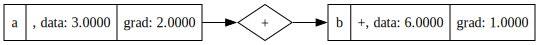

In [474]:
# Edge case, cyclic graph

a = Value(3.0, label='a')
b = a + a; b.label = 'b'

b.backward()

draw_dot(b)

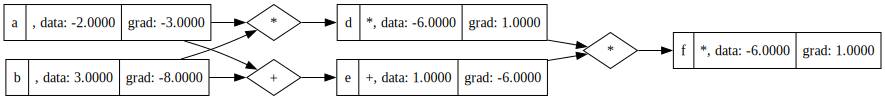

In [475]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

In [476]:
a = Value(-2.0, label='a')
b = a + 1
print(b.data)
c = 2*b
print(c.data)
print(a/b)

-1.0
-2.0
Value(data=2.0, _prev=(Value(data=-2.0, _prev=(), _op=, label=a), Value(data=-1.0, _prev=(Value(data=-1.0, _prev=(Value(data=-2.0, _prev=(), _op=, label=a), Value(data=1, _prev=(), _op=, label=)), _op=+, label=),), _op=pow, label=)), _op=*, label=)


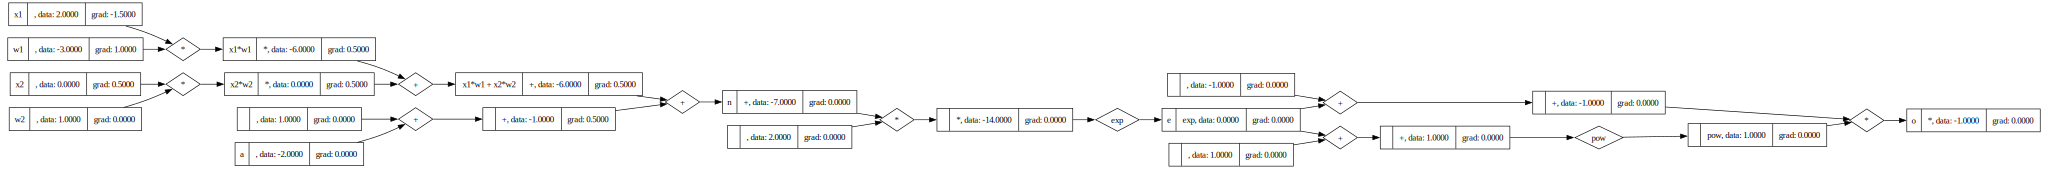

In [477]:
# a = tanh(n) = (exp(2n) - 1) / (exp(2n) + 1)
# dL/dn = 1 - tanh(n)**2 = 1 - o**2
n.grad = o.grad * (1 - o.data**2)
n.grad

x1w1x2w2.grad = n.grad
b.grad = n.grad

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

w1.grad = x1w1.grad * x1.data
x1.grad = x1w1.grad * w1.data

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'e'
o = (e - 1)/(e+1); o.label = 'o'

draw_dot(o)

### Now, same thing but with PyTorch

In [ ]:
import torch